In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import tensorflow as tf
from joblib import Parallel, delayed

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

import seaborn as sns
import cmocean as cmocn

%matplotlib inline

2025-04-01 14:19:09.749295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 14:19:09.900583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 14:19:09.900662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 14:19:09.955517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 14:19:10.010466: I tensorflow/core/platform/cpu_feature_gua

In [5]:
ds = xr.open_dataset('CCMPandBuoyDataBadQualityRemovedMatchup.nc')
df = ds.to_dataframe()
df_orig = df.copy()

In [6]:
df['cos(Direction Difference (CCMP - TAO))'] = np.cos(np.deg2rad(df['Direction Difference (CCMP - TAO)']))
df['sin(Direction Difference (CCMP - TAO))'] = np.sin(np.deg2rad(df['Direction Difference (CCMP - TAO)']))


for timeWindow in range(20,130,10):
    df[f'cos(Direction Difference (CCMP - TAO {timeWindow} min mean))'] = np.cos(np.deg2rad(df[f'Direction Difference (CCMP - TAO {timeWindow} min mean)']))
    df[f'sin(Direction Difference (CCMP - TAO {timeWindow} min mean))'] = np.sin(np.deg2rad(df[f'Direction Difference (CCMP - TAO {timeWindow} min mean)']))


Text(0.05, 0.95, 'r = 0.68')

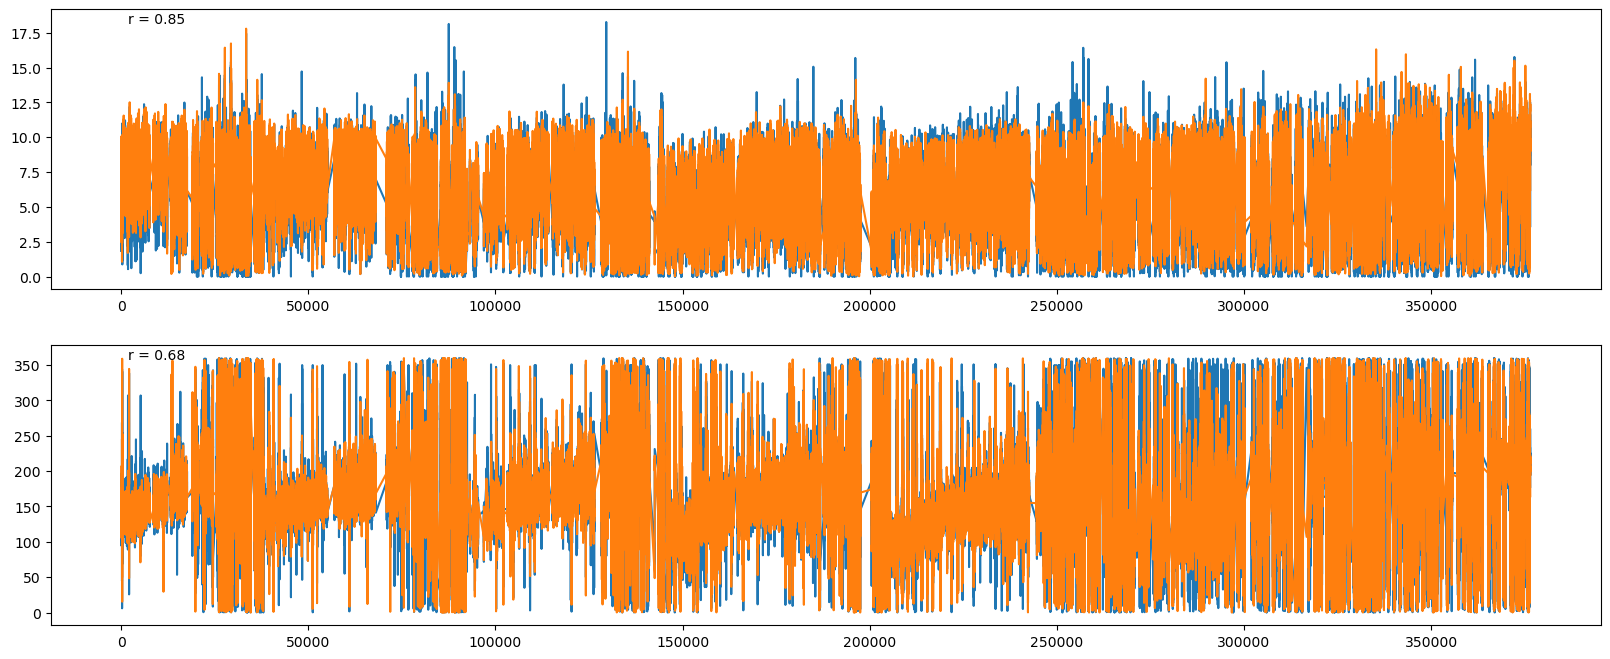

In [7]:
fig, axes = plt.subplots( nrows = 2, figsize=(20,8))
ax = axes[0]
ax.plot(df['Wind Speed (TAO)'])
ax.plot(df['Wind Speed (CCMP)'])

r = np.corrcoef(df['Wind Speed (TAO)'], df['Wind Speed (CCMP)'])[0,1]
ax.text(0.05, 0.95, f'r = {r:4.2f}', transform=ax.transAxes)


ax = axes[1]
ax.plot(df['Wind Direction (TAO)'])
ax.plot(df['Wind Direction (CCMP)'])
r = np.corrcoef(df['Wind Direction (TAO)'], df['Wind Direction (CCMP)'])[0,1]
ax.text(0.05, 0.95, f'r = {r:4.2f}', transform=ax.transAxes)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='Wind Direction (TAO)', ylabel='Wind Direction (CCMP)'>

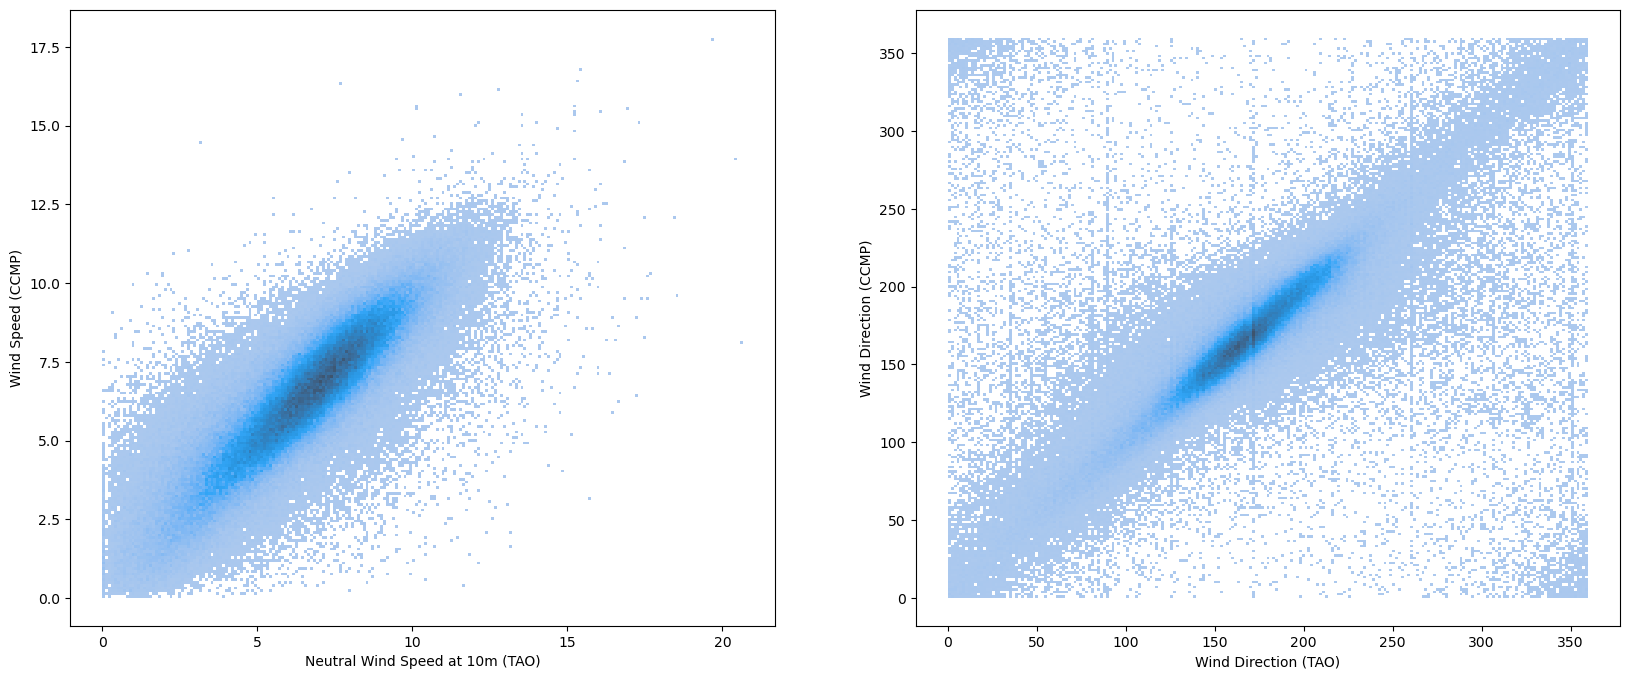

In [8]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(20,8))

ax = axes[0]
xlabel = 'Neutral Wind Speed at 10m (TAO)'
ylabel = 'Wind Speed (CCMP)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


ax = axes[1]
xlabel = 'Wind Direction (TAO)'
ylabel = 'Wind Direction (CCMP)'
sns.histplot(df, x = xlabel, y = ylabel, ax = ax)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

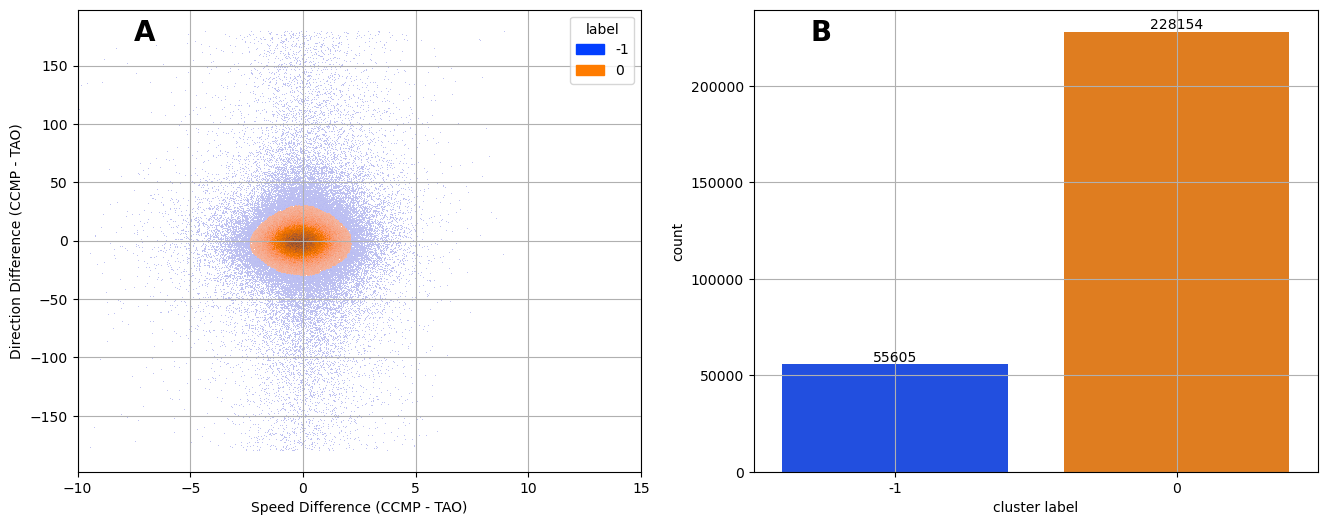

In [19]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = f'Speed Difference (CCMP - TAO)'# {timeWindow} min mean)'
ylabel = f'Direction Difference (CCMP - TAO)'# {timeWindow} min mean)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [20]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([-1])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

283759


In [21]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean WSPD_10N {timeWindow}min'
        QSspeed = subDF['Wind Speed (CCMP)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
        else:
            TAOlabel = f'mean WDIR {timeWindow}min'
        QSdir = subDF['Wind Direction (CCMP)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Ux_10N {timeWindow}min'
        QSspeed_x = subDF['Zonal Wind Speed (CCMP)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean Vy_10N {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional Wind Speed (CCMP)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


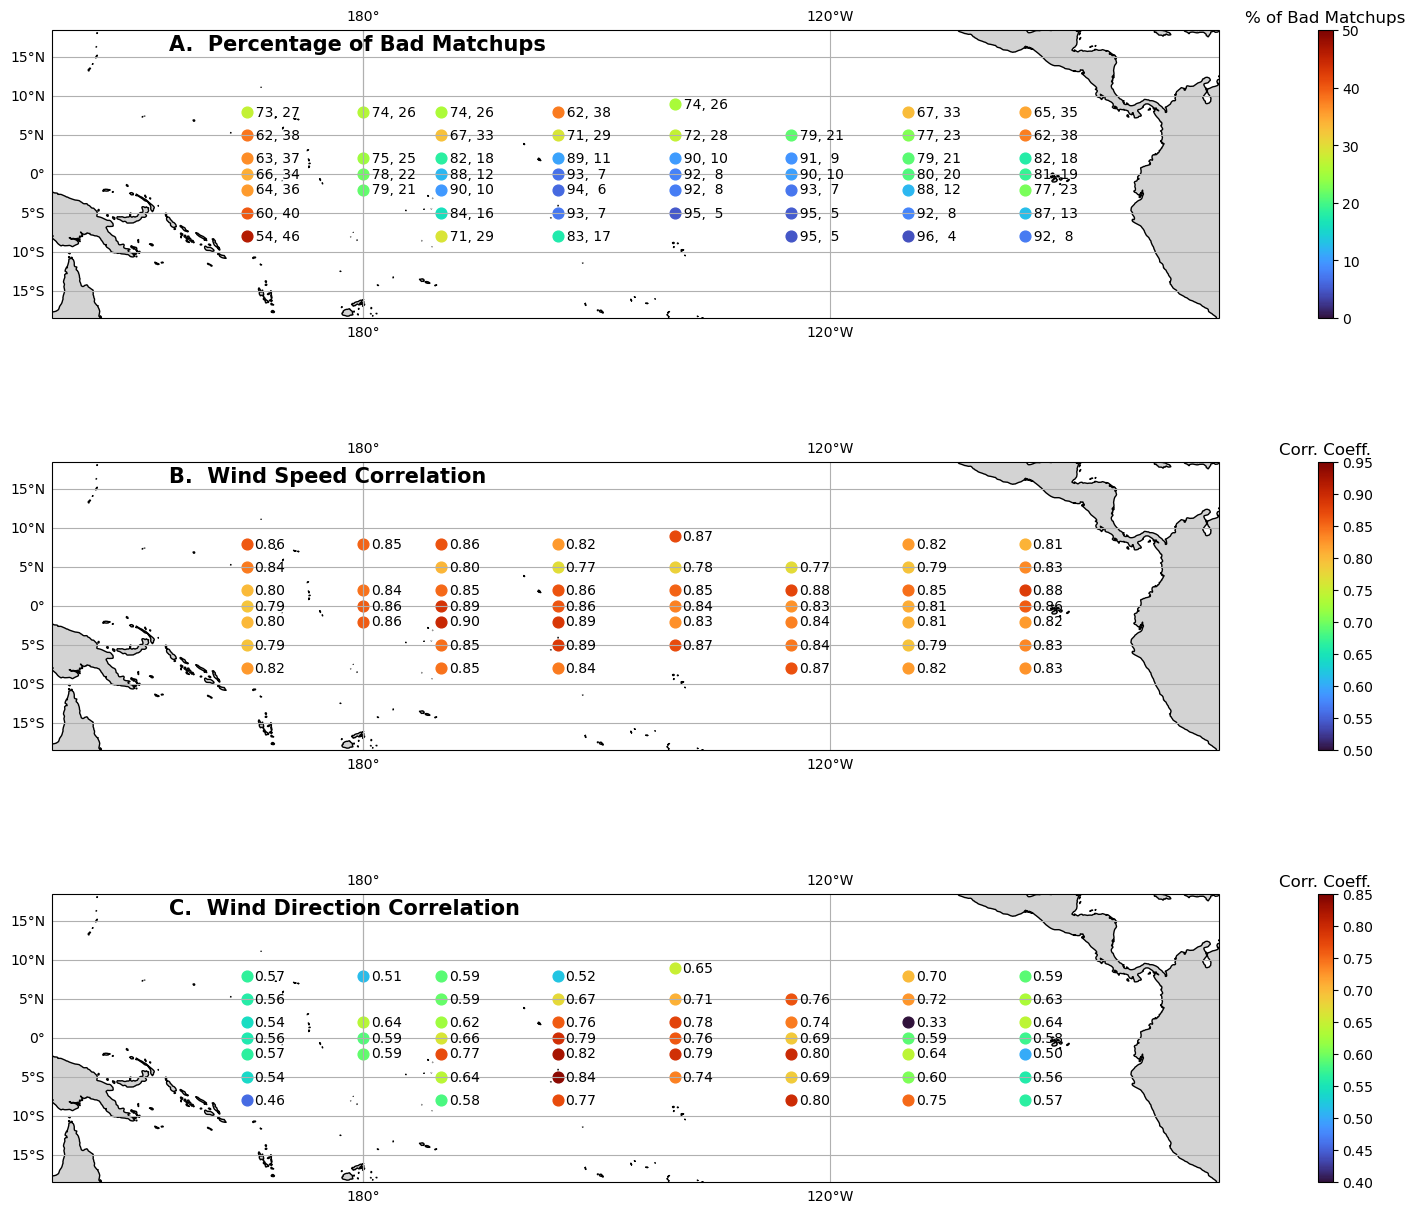

In [24]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=50, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

###################################################################################################################
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.5, vmax=0.95, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


###################################################################################################################
ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    #print(corr)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap=cm.turbo)
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

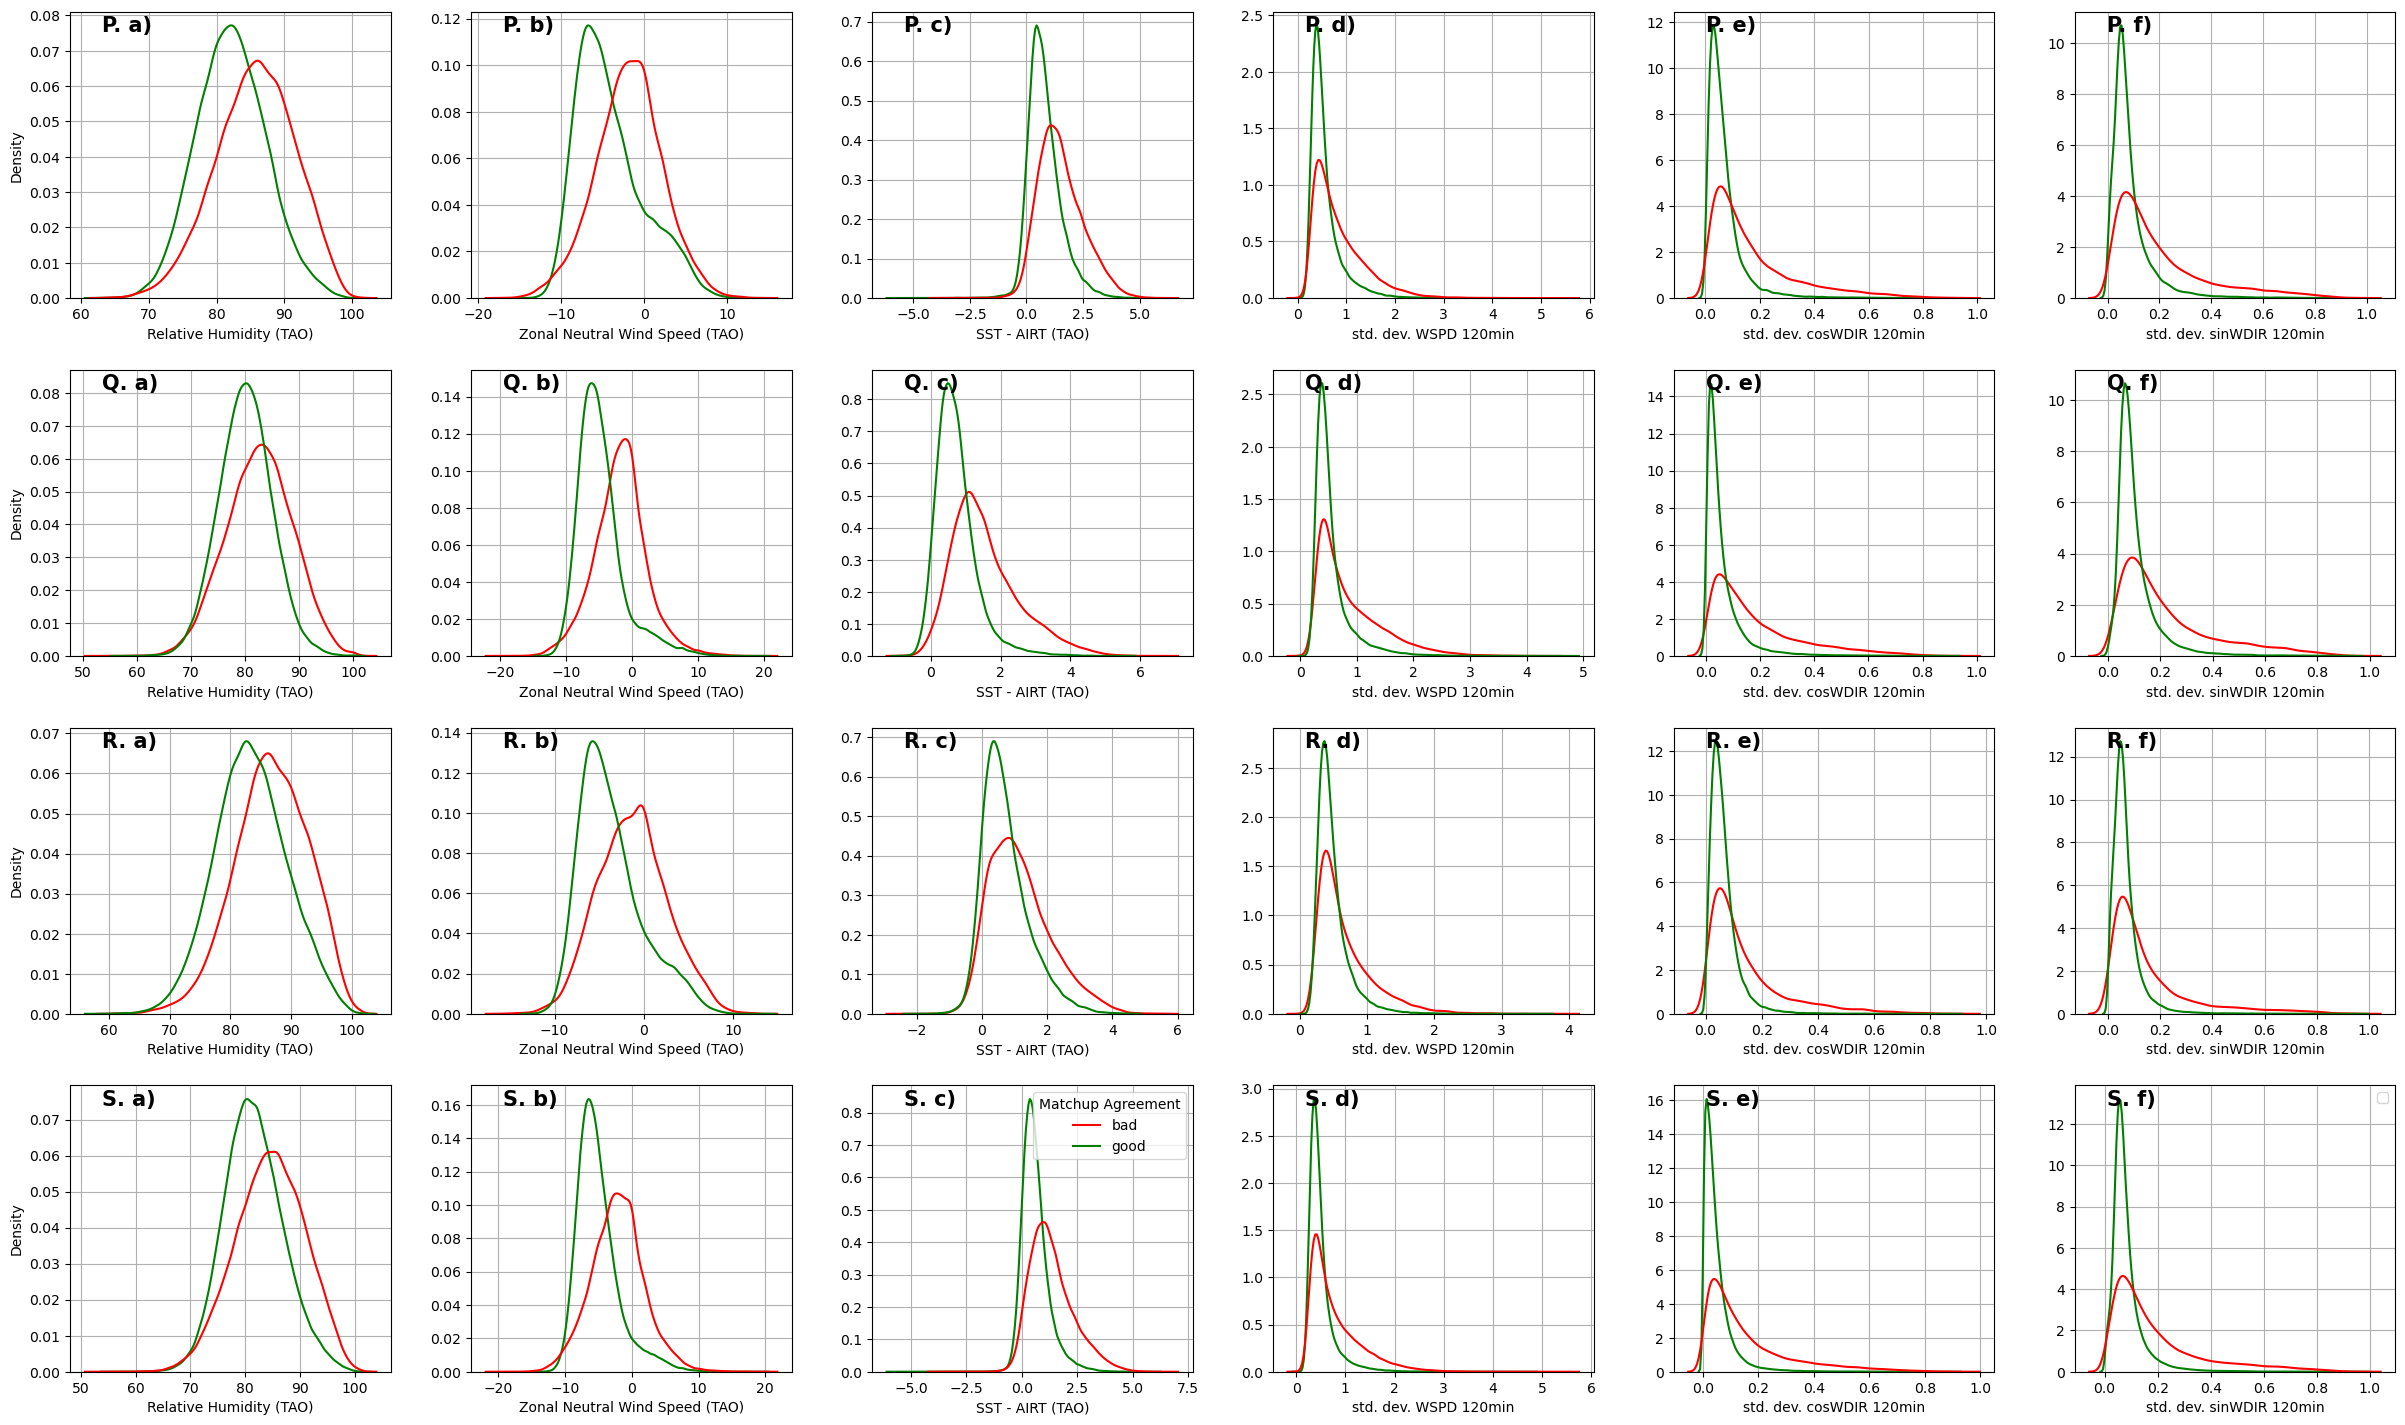

In [23]:
df['SST - AIRT (TAO)'] = df['Sea Surface Temperature (TAO)'] - df['Air Temperature (TAO)']

fig, axes = plt.subplots(nrows=4, ncols =6, sharex = False, figsize=(25,16))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10
stack_order = {'good', 'bad'}

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['LATITUDE'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)

#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[0,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'SST - AIRT (TAO)'
ax = axes[0,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'std. dev. WSPD 120min'
ax = axes[0,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[0,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[0,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'P. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['LONGITUDE'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[1,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'SST - AIRT (TAO)'
ax = axes[1,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)



xlabel = 'std. dev. WSPD 120min'
ax = axes[1,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[1,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[1,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'Q. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


################################################################################################
xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['LONGITUDE'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)


xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[2,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST - AIRT (TAO)'
ax = axes[2,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


xlabel = 'std. dev. WSPD 120min'
ax = axes[2,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[2,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[2,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'R. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


################################################################################################
################################################################################################

xlabel = 'Relative Humidity (TAO)'
title = 'For Buoy locations lon < -165 E '
ax = axes[3,0]
subDF = df.copy()
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#x.set_xlabel('TAO Relative Humidity')
#ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. a)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'Zonal Neutral Wind Speed (TAO)'
ax = axes[3,1]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. b)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'SST - AIRT (TAO)'
ax = axes[3,2]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'},
             legend=True,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. c)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. WSPD 120min'
ax = axes[3,3]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. d)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. cosWDIR 120min'
ax = axes[3,4]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. e)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

xlabel = 'std. dev. sinWDIR 120min'
ax = axes[3,5]

sns.kdeplot(subDF.iloc[::-1], x=xlabel, 
             #bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             #multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
            legend=False,
             #hue_order=stack_order,
             common_norm = False, 
             ax = ax)
#ax.set_title(title)
#ax.set_xlabel('TAO Zonal winds')
ax.set_ylabel('')
ax.grid(visible=True, which='major')
ax.text(0.1, 0.95, 'S. f)', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.legend()

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
#plt.savefig('StackedHistogram.png', dpi = 100)